In [13]:
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import imgaug as ia
import imgaug.augmenters as iaa

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
import skimage
import os
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
import scipy.misc
import imageio
import pandas as pd
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import img_as_ubyte
import cv2
from scipy import ndimage
from sklearn.utils import resample
import itertools

In [14]:
DATASET_PATH = r"../dataset/"
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
EPOCHS = 30
BATCH_SIZE = 32
SEED = 42
dataset_folders = []  # to keep main folder names
total = 0
print(f"There are {len(os.listdir(DATASET_PATH))} folder in dataset.")
for path in sorted(os.listdir(DATASET_PATH)):
    print(f"\t-There are {len(os.listdir(DATASET_PATH + path))} images in {path} folder.")
    total += len(os.listdir(DATASET_PATH + path))  # add element size of the current folder to total variable
    dataset_folders.append(DATASET_PATH + path)  # add current folder path to dataset_folders

# Create an empty dataframe
df = pd.DataFrame(0,
                  columns=['paths',
                           'class_label'],
                  index=range(total))
# store each image path in the dataframe
# class labels -> 0:Normal 1:Cataract 2:Glaucoma 3:RetinaDisease
i = 0
for p, path in enumerate(dataset_folders):  # main folders
    for sub_path in sorted(os.listdir(path)):  #images
        df.iloc[i, 0] = path + "/" + sub_path
        df.iloc[i, 1] = p
        i += 1
# Display some examples for the created DataFrame
# print(df.sample(frac=1, random_state=SEED).head(10))
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df['class_label'])

There are 4 folder in dataset.
	-There are 300 images in 1_normal folder.
	-There are 100 images in 2_cataract folder.
	-There are 101 images in 2_glaucoma folder.
	-There are 100 images in 3_retina_disease folder.


In [15]:
def create_dataset(df):
    # Creating dataset
    images = []
    labels = []
    index = 0
    for path in tqdm(df['paths']):
        #According to parameter, we apply some preprocesses here. default=0
        img = cv2.imread(path)  #read image from file
        img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        label = [0, 0, 0, 0]
        label[df.iloc[index]["class_label"]] += 1
        index += 1
        images.append(img)
        labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [16]:
# Creating dataset and split the data
images, labels = create_dataset(df)
labels_names = ["Normal", "Cataract", "Glaucoma", "Retina Disease"]

100%|██████████| 601/601 [00:40<00:00, 14.79it/s]


In [17]:
red = cv2.calcHist(images,[0],None,[256],[0,256])
green = cv2.calcHist(images,[1],None,[256],[0,256])
blue = cv2.calcHist(images,[2],None,[256],[0,256])

Text(0.5, 1.0, 'Color Distribution on Raw Data')

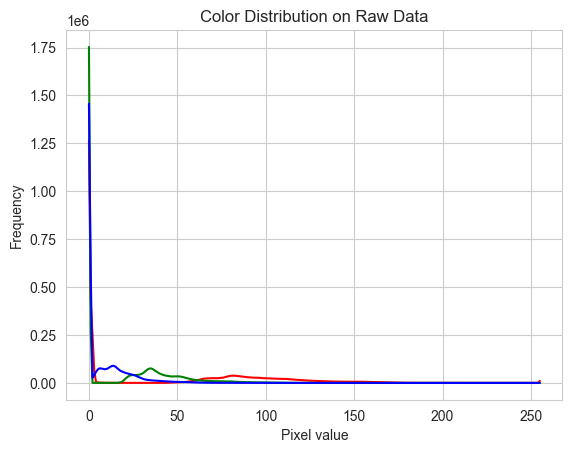

In [18]:
plt.plot(red,color='r')
plt.plot(green,color='g')
plt.plot(blue,color='b')
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.title("Color Distribution on Raw Data")

In [19]:
#Cropping image to avoid from unnecessary black areas
def deleteBlackAreas(filename):
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    img = cv2.imread(filename)  #read image from file
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)  # turn it into a binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # find contours
    if len(contours) != 0:
        #find the biggest area
        cnt = max(contours, key=cv2.contourArea)

        #find the bounding rect
        x, y, w, h = cv2.boundingRect(cnt)

        crop = img[y:y + h, x:x + w]  # crop image
        crop1 = cv2.cvtColor(cv2.resize(crop, image_size, interpolation=cv2.INTER_AREA),
                             cv2.COLOR_BGR2RGB)  # resize to image_size and change color space from BGR to RGB for matplotlib
        return crop1
    else:
        return cv2.cvtColor(cv2.resize(img, image_size, interpolation=cv2.INTER_AREA), cv2.COLOR_BGR2RGB)

def create_dataset_2(df):
    # Creating dataset
    images = []
    labels = []
    index = 0
    for path in tqdm(df['paths']):
        #According to parameter, we apply some preprocesses here. default=0
        img = deleteBlackAreas(path)  #deleting black areas. Initial preprocess
        label = [0, 0, 0, 0]
        label[df.iloc[index]["class_label"]] += 1
        index += 1
        images.append(img)
        labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images,labels

In [20]:
# Creating dataset and split the data
images, labels = create_dataset_2(df)


100%|██████████| 601/601 [00:45<00:00, 13.22it/s]


In [21]:
red = cv2.calcHist(images, [0], None, [256], [0, 256])
green = cv2.calcHist(images, [1], None, [256], [0, 256])
blue = cv2.calcHist(images, [2], None, [256], [0, 256])


Text(0.5, 1.0, 'Color Distribution after 1st Preprocess')

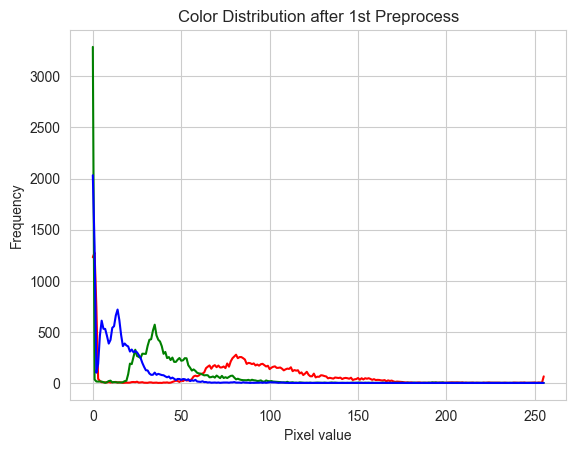

In [22]:
plt.plot(red, color='r')
plt.plot(green, color='g')
plt.plot(blue, color='b')
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.title("Color Distribution after 1st Preprocess")